# EWMA Forecast trainer

In [54]:
#Create progress bar function
def progress_bar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = '\r')
    if iteration == total: 
        print()

colors = [ '#EE8866', '#77AADD', '#AAAA00', '#EEDD88', '#FFAABB', '#99DDFF', '#44BB99', '#DDDDDD']

In [49]:
# Importing the libraries
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import matplotlib.pyplot as plt

# define functions for RMSE and MAPE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

days=4

# Importing the dataset
market_prices = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['price[EUR/MWh]'].values
dates = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['date'].values
wind_speed = pd.read_csv('/Users/jonathan/Desktop/Opportunistic_OM_WIND/Data/CLEAN_combined_data/2019_2023_final.csv')['wind_speed'].values

In [50]:
# Create a DataFrame
data = []
for i in range(len(market_prices)-days*24):
    data.append([market_prices[i], dates[i]])#, wind_speed[i+days*24]]) # append the price, date and wind speed (windspeed is shifted by days)

data = pd.DataFrame(data, columns=['price', 'date'])
# remove duplicate rows
data = data.drop_duplicates()

# Convert 'date' to datetime, ensuring timezone info is retained if present
data['date'] = pd.to_datetime(data['date'], utc=True)

# If the data isn't timezone-aware, assume it's UTC and then convert. Otherwise, directly convert.
data['date'] = data['date'].dt.tz_convert('Europe/Copenhagen')  # Converting to Copenhagen timezone

data = data.set_index('date')

In [51]:
# EWMA function by hour of day
def ewma_forecast_by_hour(df, alpha):
    forecast = pd.Series(index=df.index, dtype=float)
    
    ewma = np.zeros(24)

    # Loop over each hour of the day (0 to 23)
    for hour in range(24):
        hour_data = df[df.index.hour == hour]['price']
        #forecast.loc[hour_data.index] = ewma
        ewma[hour] = sum(alpha*(1-alpha)**i * hour_data.iloc[hour_data.shape[0]-1-i] for i in range(len(hour_data)))
    return ewma

In [52]:
alphas = np.linspace(0.001,0.999,10)  # Smoothing factor

days_to_forecast = 365
forecast_errors = []
for alpha in alphas:
    all_forecasts = []
    # progress bar
    progress_bar(alpha, alphas[-1], prefix = 'Progress:', suffix = 'Complete', length = 50)
    for d in range(days_to_forecast):
        #progress bar
        end_date = pd.Timestamp('2020-12-31 23:00:00+0100', tz='Europe/Copenhagen') + pd.Timedelta(days=d)
        forecast_one_day = ewma_forecast_by_hour(data[data.index<=end_date], alpha)
        all_forecasts.append(forecast_one_day)
    forecast_errors.append(rmse(np.array(data[(data.index > pd.Timestamp('2020-12-31 23:00:00+0100', tz='Europe/Copenhagen')) & 
                                     (data.index <= pd.Timestamp('2020-12-31 23:00:00+0100', tz='Europe/Copenhagen') + pd.Timedelta(days=days_to_forecast))]['price']),
                                np.array(all_forecasts).reshape(-1,1)))

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [55]:
# Find the best alpha based on forecast_errors
best_alpha = alphas[np.argmin(forecast_errors)]
print(f'The best alpha is {best_alpha}')

The best alpha is 0.11188888888888888


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


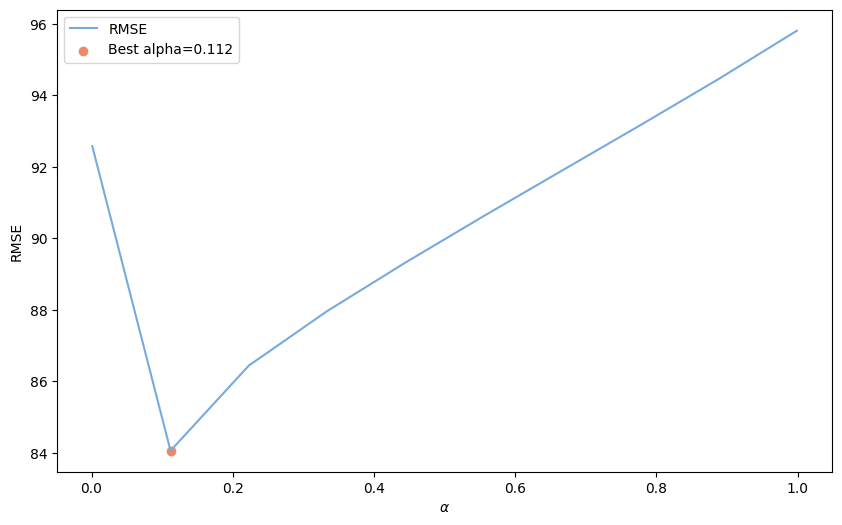

In [61]:
plt.figure(figsize=(10,6))
plt.plot(alphas, forecast_errors, color= colors[1], label='RMSE')
plt.xlabel(r'$\alpha$')
plt.ylabel('RMSE')
# insert the best level for alpha
plt.scatter(x=best_alpha, y=forecast_errors[np.argmin(forecast_errors)], color=colors[0], label='Best alpha='+str(round(best_alpha,3)))
plt.legend()
plt.savefig('../Figures/EWMA_alpha.eps', bbox_inches='tight')

In [62]:
days_to_forecast = 365
forecast_errors = []
alphas = [best_alpha]
for alpha in alphas:
    all_forecasts = []
    for d in range(days_to_forecast):
        #progress bar
            # progress bar
        progress_bar(d, days_to_forecast, prefix = 'Progress:', suffix = 'Complete', length = 50)
        end_date = pd.Timestamp('2020-12-31 23:00:00+0100', tz='Europe/Copenhagen') + pd.Timedelta(days=d)
        forecast_one_day = ewma_forecast_by_hour(data[data.index<=end_date], alpha)
        all_forecasts.append(forecast_one_day)
    forecast_errors.append(rmse(np.array(data[(data.index > pd.Timestamp('2021-12-31 23:00:00+0100', tz='Europe/Copenhagen')) & 
                                     (data.index <= pd.Timestamp('2021-12-31 23:00:00+0100', tz='Europe/Copenhagen') + pd.Timedelta(days=days_to_forecast))]['price']),
                                np.array(all_forecasts).reshape(-1,1)))

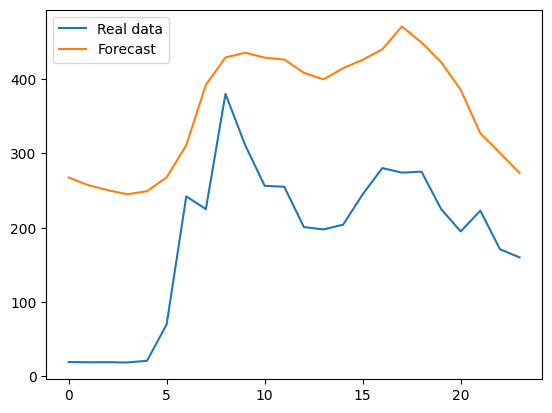

In [26]:
d = 350
start_date = pd.Timestamp('2021-01-01 00:00:00+0100', tz='Europe/Copenhagen') + pd.Timedelta(days=d)
end_date = pd.Timestamp('2021-01-01 23:00:00+0100', tz='Europe/Copenhagen') + pd.Timedelta(days=d)
real_data = data[(data.index<=end_date) & (data.index>=start_date)]
plt.plot(range(24),real_data.price.values, label='Real data')
plt.plot(all_forecasts[d], label='Forecast')
plt.legend()